<a href="https://colab.research.google.com/github/mohamedyosef101/101_learning_area/blob/area/Time%20Series/airbnb_paris_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Analysis** with Airbnb Paris Reviews data
This is me following [Pydata LA 2018 Tutorial](https://youtu.be/JntA9XaTebs?si=PV4DMpbuHljg6WK9) by [Tamara Louie](https://www.linkedin.com/in/tklouie/)

# 1. Get the data
**Source**: [Inside Airbnb](http://insideairbnb.com/get-the-data/). *choose any city and download the file with the name `reviews.csv`*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os

# set the visualization style
sns.set_style('whitegrid', {'grid.color': 'lightgray'})

# read the data
URL = 'http://data.insideairbnb.com/france/ile-de-france/paris/2023-12-12/visualisations/reviews.csv'
data = pd.read_csv(URL)
data.head()

,listing_id,date
0,3109,2017-10-28
1,3109,2017-11-03
2,3109,2018-07-24
3,3109,2019-10-24
4,5396,2009-06-30


# 2. **Look** at the data

In [2]:
# How many rows and columns are in this dataset
data.shape

(1721452, 2)

In [3]:
# what data types are the columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1721452 entries, 0 to 1721451
Data columns (total 2 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   listing_id  int64 
 1   date        object
dtypes: int64(1), object(1)
memory usage: 26.3+ MB


In [4]:
# Is the data complete? Are there nulls? Do we have to infer values?
data.isnull().any()

listing_id    False
date          False
dtype: bool

**What is the definition of these columns?**
* `listing_id`: a unique identifier for the listings
* `date`: time points when data recording


# 3. Data Preprocessing

In [5]:
# Rename columns
data = data.rename(columns = {'date': 'ds', 'listing_id': 'ts'})

# group data by the number of listings per date
example = data.groupby(by = 'ds').agg({'ts': 'count'})

# change index to datetime
example.index = pd.to_datetime(example.index)

# set the frequency to be one day
example = example.asfreq(freq='D')

# make sure that the data is sorted
example = example.sort_index(ascending=True)

# fill nan values with 0
example = example.fillna(value=0)

# show the data example
example.head(10)

,ts
ds,
2009-06-30,1.0
2009-07-01,0.0
2009-07-02,0.0
2009-07-03,1.0
2009-07-04,0.0
2009-07-05,0.0
2009-07-06,0.0
2009-07-07,0.0
2009-07-08,1.0


# 4. Visualize the data

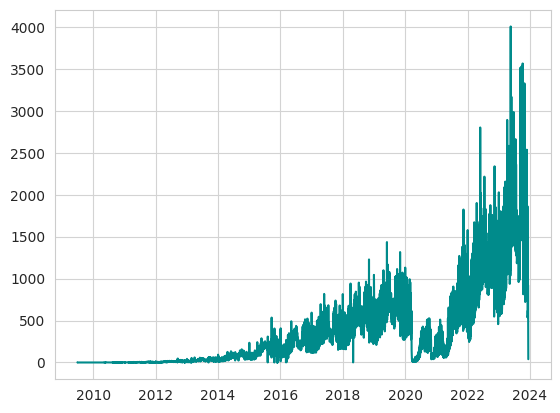

In [6]:
plt.plot(example['ts'], color="darkcyan")
plt.grid(True)

# 5. Test stationarity

Most time-series models assume that the underlying time-series data is **stationary**. This assumption gives us some nice statistical properties that allows us to use various models for forecasting.

<div><br></div>

**Stationarity** is a statistical assumption that a time-series has:
* **Constant mean**
* **Constant variance**
* **Autocovariance does not depend on time**

<div><br></div>

More simply put, if we are using past data to predict future data, we should assume that the data will follow the same general trends and patterns as in the past. This general statement holds for most training data and modeling tasks.

In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(df, ts):
  # determing rolling statistics
  rolmean = df[ts].rolling(window=12, center=False).mean()
  rolstd = df[ts].rolling(window=12, center=False).std()

  # plot
  original = plt.plot(df[ts], color='gray', label='Original')
  mean = plt.plot(rolmean, color='crimson', label='Rolling mean')
  std = plt.plot(rolstd, color='darkcyan', label='Rolling std')

  plt.legend(loc='best')
  plt.title(f'Rolling mean and std for {ts}')
  plt.show()

  # perform dickey-fuller test:
  # H_0: data is not stationary
  # H_1: data is stationary

  print('\nResults of Dickey-Fuller Test:')
  adftest = adfuller(df[ts], autolag='AIC')
  dfoutput = pd.Series(adftest[0:4],
                       index=['Test Statistic',
                              'p-value',
                              'Num of Lags used',
                              'Num of observations used'])
  for key, value in adftest[4].items():
    dfoutput[f'Critical Value {key}'] = value
  print(dfoutput, '\n\n')

  if dfoutput['p-value'] > 0.05:
    print("Failed to reject H_0 and data is not stationary")
  else:
    print("Reject H_0 and data is stationary ✅")

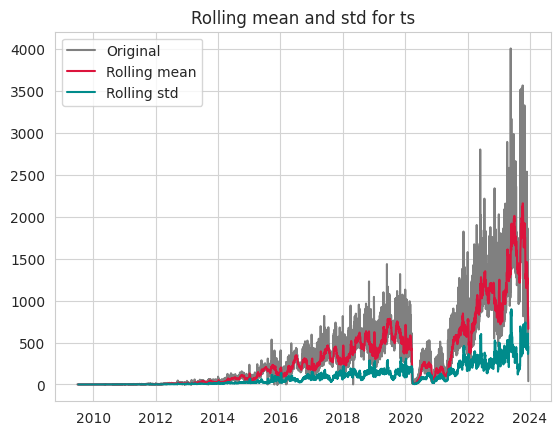


Results of Dickey-Fuller Test:
Test Statistic                -2.371520
p-value                        0.149937
Num of Lags used              32.000000
Num of observations used    5247.000000
Critical Value 1%             -3.431597
Critical Value 5%             -2.862091
Critical Value 10%            -2.567063
dtype: float64 


Failed to reject H_0 and data is not stationary


In [8]:
# run the test
test_stationarity(df=example, ts='ts')

> Rolling mean and standard deviation look like they change over time. There may be some de-trending and removing seasonality involved. Based on **Dickey-Fuller test**, because p = 0.15, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that we fail to reject the null hypothesis that our **time series is not stationary**.

# 6. Correct for stationarity

Two common reasons behind non-stationarity are:
1. **Trend** -- mean is not constant over time.
2. **Seasonality** -- variance is not constant over time.

**What if you don't correct for stationarity?**
* Variance can be mis-specified
* Model fit can be worse.
* Not leveraging valuable time-dependent nature of the data.

### Techniques for eliminating trend and seasonality
- **Transformation**: Log, square root, etc.
- **Smoothing**: Weekly average, monthly average, rolling averages.
- **Differencing**: First-order differencing.
- **Polynomial Fitting**: fit a regression model
- **Decomposition**

In [9]:
def plot_transformed_data(df, ts, ts_transform):
  """
  Plot original and transformed time series data
  """
  plt.plot(df[ts], color='darkgray')
  plt.plot(df[ts_transform], color='black')
  plt.title(f"Original vs. {ts_transform}")
  plt.show()

## Transformations
Applying log transformation, weekly moving average smoothing, and differencing made the data more stationary over time. Based on **Dickey-Fuller test**, because p = < 0.05, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that the **time series is stationary**.

In [10]:
# Log transformation (handle zeros)
example['ts_log'] = np.log(np.where(example['ts'] > 0, example['ts'], 1e-8))

# Moving averages (window=7, no centering)
window = 7
example['ts_log_moving_avg'] = example['ts_log'].rolling(window).mean()
example['ts_moving_avg'] = example['ts'].rolling(window).mean()

# Differencing
example['ts_log_diff'] = example['ts_log'].diff()
example['ts_moving_avg_diff'] = example['ts'] - example['ts_moving_avg']
example['ts_log_moving_avg_diff'] = example['ts_log'] - example['ts_log_moving_avg']

# get rid of nan values
example = example.dropna()

# Display the data
example.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5274 entries, 2009-07-06 to 2023-12-13
Freq: D
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ts                      5274 non-null   float64
 1   ts_log                  5274 non-null   float64
 2   ts_log_moving_avg       5274 non-null   float64
 3   ts_moving_avg           5274 non-null   float64
 4   ts_log_diff             5274 non-null   float64
 5   ts_moving_avg_diff      5274 non-null   float64
 6   ts_log_moving_avg_diff  5274 non-null   float64
dtypes: float64(7)
memory usage: 329.6 KB


### Plot transformed data

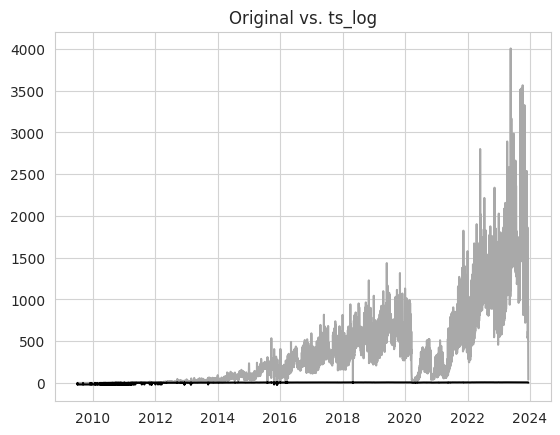

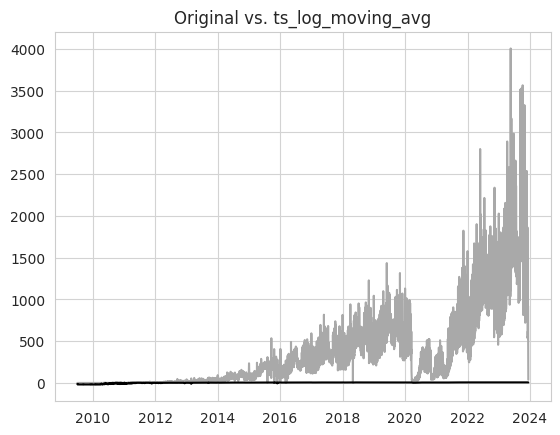

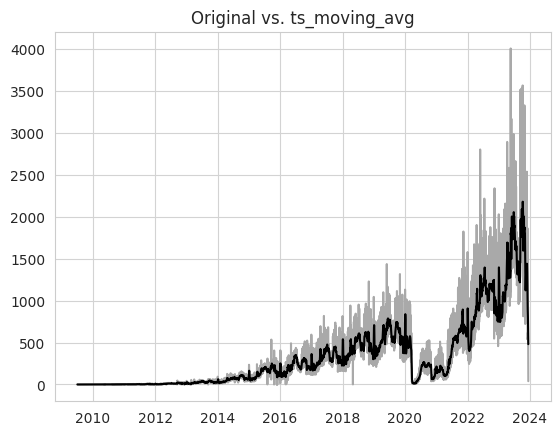

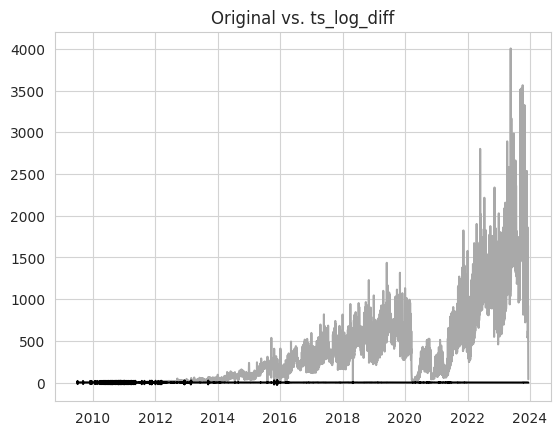

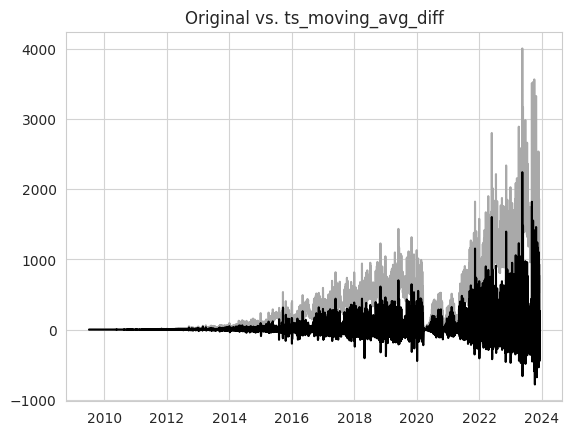

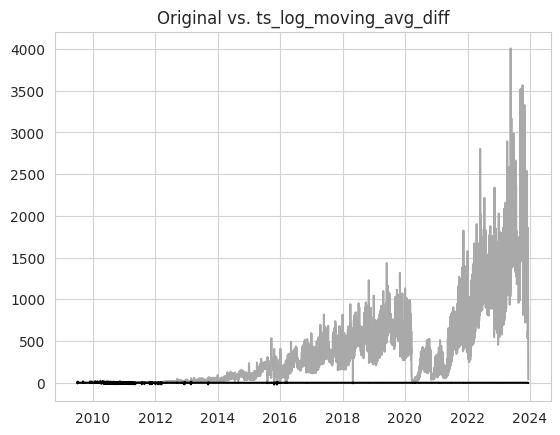

In [11]:
transformed_cols = example.drop('ts', axis=1)
transformed_cols = transformed_cols.columns
for col in transformed_cols:
  plot_transformed_data(df=example, ts= 'ts', ts_transform=col)
  print("\n\n=======================================\n\n")

### Test stationarity for transformed data

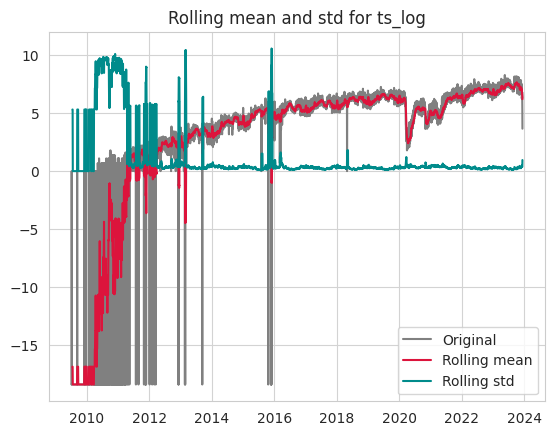


Results of Dickey-Fuller Test:
Test Statistic                -3.717232
p-value                        0.003877
Num of Lags used              32.000000
Num of observations used    5241.000000
Critical Value 1%             -3.431598
Critical Value 5%             -2.862092
Critical Value 10%            -2.567064
dtype: float64 


Reject H_0 and data is stationary ✅






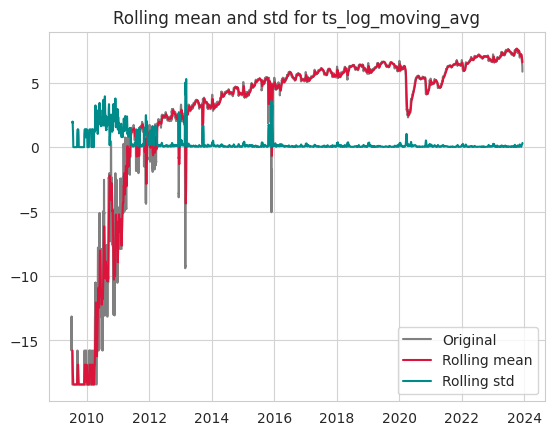


Results of Dickey-Fuller Test:
Test Statistic                -3.768223
p-value                        0.003250
Num of Lags used              33.000000
Num of observations used    5240.000000
Critical Value 1%             -3.431599
Critical Value 5%             -2.862092
Critical Value 10%            -2.567064
dtype: float64 


Reject H_0 and data is stationary ✅






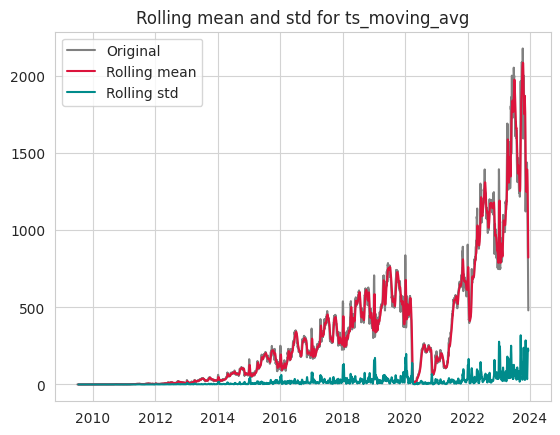


Results of Dickey-Fuller Test:
Test Statistic                -2.332821
p-value                        0.161601
Num of Lags used              33.000000
Num of observations used    5240.000000
Critical Value 1%             -3.431599
Critical Value 5%             -2.862092
Critical Value 10%            -2.567064
dtype: float64 


Failed to reject H_0 and data is not stationary






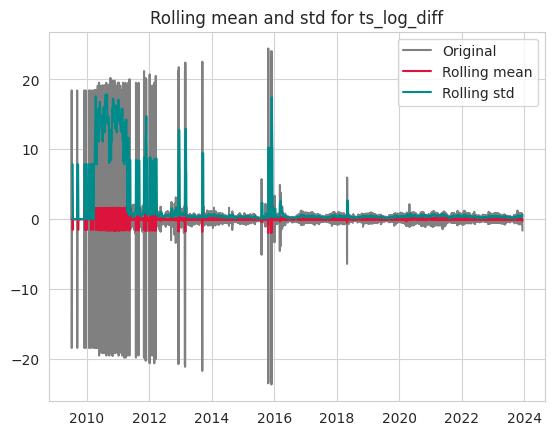


Results of Dickey-Fuller Test:
Test Statistic               -18.951267
p-value                        0.000000
Num of Lags used              33.000000
Num of observations used    5240.000000
Critical Value 1%             -3.431599
Critical Value 5%             -2.862092
Critical Value 10%            -2.567064
dtype: float64 


Reject H_0 and data is stationary ✅






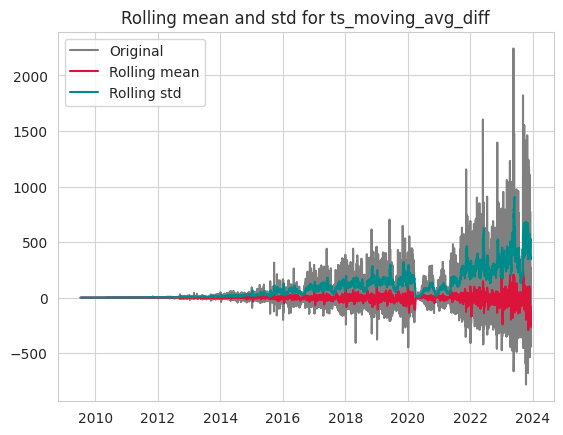


Results of Dickey-Fuller Test:
Test Statistic             -1.252978e+01
p-value                     2.443136e-23
Num of Lags used            2.800000e+01
Num of observations used    5.245000e+03
Critical Value 1%          -3.431597e+00
Critical Value 5%          -2.862091e+00
Critical Value 10%         -2.567063e+00
dtype: float64 


Reject H_0 and data is stationary ✅






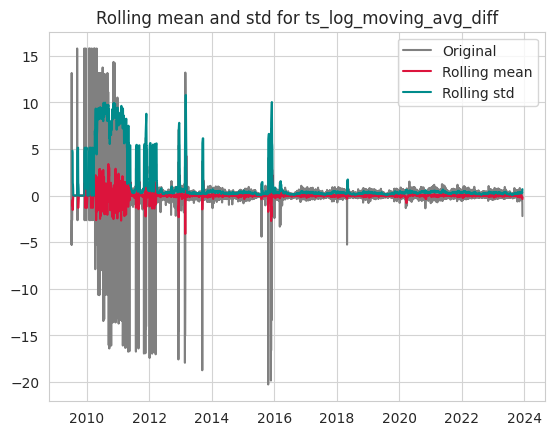


Results of Dickey-Fuller Test:
Test Statistic               -19.077200
p-value                        0.000000
Num of Lags used              30.000000
Num of observations used    5243.000000
Critical Value 1%             -3.431598
Critical Value 5%             -2.862091
Critical Value 10%            -2.567064
dtype: float64 


Reject H_0 and data is stationary ✅






In [12]:
for col in transformed_cols:
  test_stationarity(df=example, ts=col)
  print("\n\n=============================\n\n")

## Decomposition: trend, seasonality, residuals

In [13]:
def plot_decomposition(df, ts, trend, seasonal, residual):
  """
  Plot time series decomposition
  """
  labels = ['Original', 'Trend', 'Seasonality', 'Residuals']
  data = [df[ts], df[trend], df[seasonal], df[residual]]

  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 5), sharex=True)
  for ax, label, datum in zip([ax1, ax2, ax3, ax4], labels, data):
      ax.plot(datum, label=label, color='darkcyan')
      ax.legend(loc='best')
      ax.tick_params(axis='x')
  plt.tight_layout()
  plt.suptitle(f'Trend, Seasonal, and Residual Decomposition of {ts}',
               x=0.5, y=1.05, fontsize=18)
  plt.show()

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(example['ts_log'], extrapolate_trend=365)
example['trend'] = decomposition.trend
example['seasonal'] = decomposition.seasonal
example['residual'] = decomposition.resid

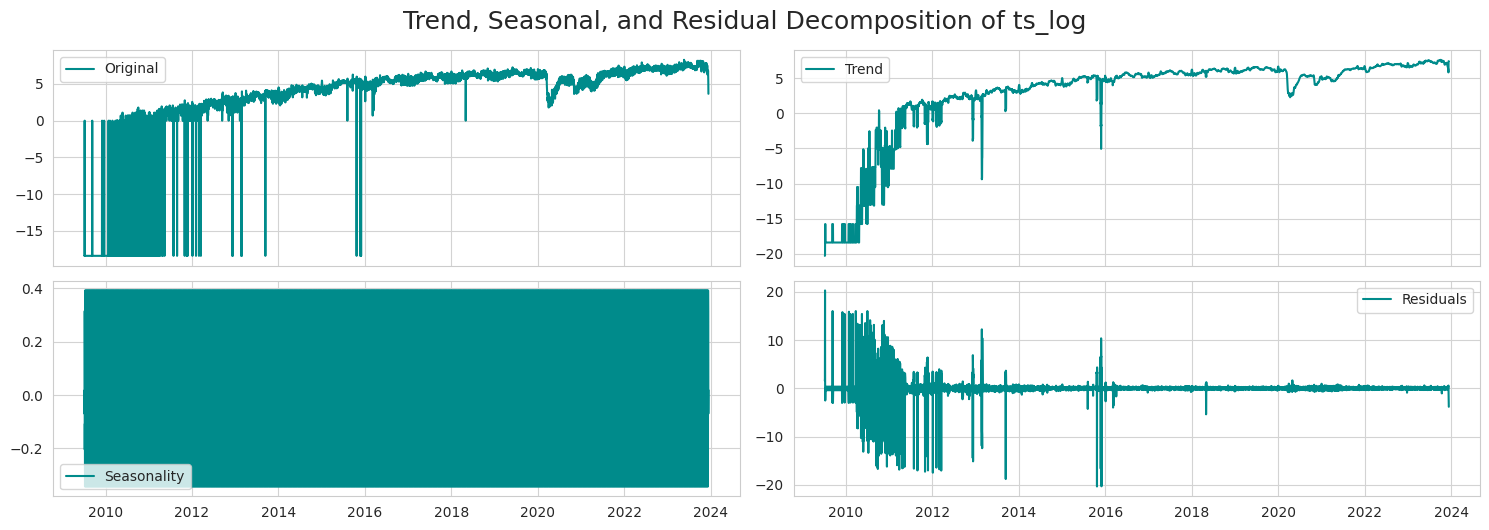

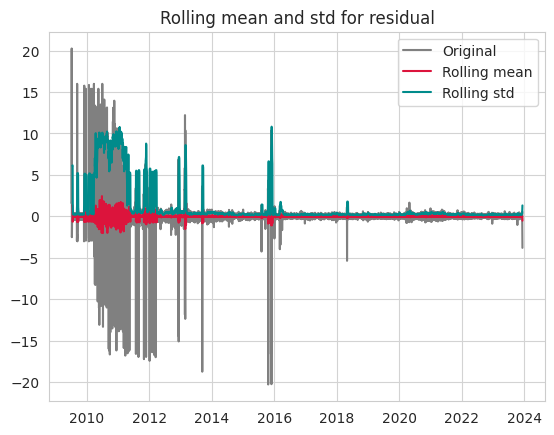


Results of Dickey-Fuller Test:
Test Statistic               -25.818046
p-value                        0.000000
Num of Lags used              33.000000
Num of observations used    5240.000000
Critical Value 1%             -3.431599
Critical Value 5%             -2.862092
Critical Value 10%            -2.567064
dtype: float64 


Reject H_0 and data is stationary ✅


In [15]:
# plot
plot_decomposition(df=example, ts='ts_log', trend='trend',
                   seasonal='seasonal', residual='residual')
test_stationarity(df=example, ts='residual')